# Read data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns

In [2]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [3]:
target_classes = df['STAT_CAUSE_DESCR'].unique()

In [4]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Null columns

In [5]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


In [6]:
# null_columns = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
#                 'FIRE_CODE', 'FIRE_NAME',
#                 'ICS_209_INCIDENT_NUMBER',  'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
#                 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
#                 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']

# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']



There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [7]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Little note here: we tried to pass some columns with empty values to the model, since XGB is able to fill in te blank. However, the train error will be lower but the validation error is higher.

# Catagorical

We will try to use frequency encoding for every thing. Except for null columns and states.

In [8]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE',
               'STATE'
               ]
catagorical_features = HC_features + LC_features

In [9]:
#  generic function for frequency encoding
from sklearn.preprocessing import LabelEncoder
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder

def frequency_encoding(df):
  for feature in catagorical_features:
    le = frequency_encoder_map[feature]
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

In [10]:
# train the frequency encoders
train_frequency_encoders(X_train)

Little note here: if just simply pass catagorical data to to XGB will not make it better. I am assuming XGB is using one hot embedding.

# Geo Spacial data

## STATE

During the EDA we found out that being in certain state will affect the distribution of the final label. So what we are going to do is that, for each label, we will find the top k states that is highly correlated to the label, and we will generate a feature that says "is the sample in either of these k states".

In [11]:
state_significance = {}

def train_state_encoders(df):
  # find out for each class which states will have higher than normal percentage of the class instance.
  percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
  cross_Vals = pd.crosstab(df['STATE'], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)

  # For each class, we will encode each state to "how important they are to prediction the class"
  for target_class in target_classes:
    state_significance_per_class = {}
    for state in cross_Vals.index:
      significance = cross_Vals.loc[state, target_class]
      state_significance_per_class[state] = significance
    state_significance[target_class] = state_significance_per_class




In [12]:
train_df = pd.concat([X_train, y_train], axis=1)
train_state_encoders(train_df)

In [13]:
def state_encoding(df):
  for target_class in target_classes:
    df['SE-'+ target_class] = df['STATE'].map(state_significance[target_class])
  return df

# XGBoost

## Preparation

In [14]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
state_encoding_features = ['SE-' + target_class for target_class in target_classes]
selected_features = encoded_catagorical_features + encoded_null_features + state_encoding_features

In [15]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(y)
def transform_y_for_XGB(y):
  return target_encoder.transform(y)

def transform_X_for_XGB(X):
  # frequency encoding
  X = frequency_encoding(X)

  # null encoding
  X = null_encoding(X)

  # state encoding
  X = state_encoding(X)

  # select feature for training
  X = X[selected_features]
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})
  return X

# putting everything together so that it's easier
def transform_data_for_XGB(X, y):
  return transform_X_for_XGB(X), transform_y_for_XGB(y)

In [16]:
X_train, y_train = transform_data_for_XGB(X_train, y_train)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [17]:
# save the files to drive, so that we can switch to GPU
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
dump_file(y_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
dump_file(X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
dump_file(y_val, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
dump_file(target_encoder, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


## Training (Can switch to GPU)

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')


In [2]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    # "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": True,
    # "eval_metric": auc_ovr,
    #  "n_estimators": 2,
    # "max_cat_to_onehot": 4
    # "colsample_bylevel": 0.7,
    # 'objective':'multi:softmax',  # for multi-class classification
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:2.10946	validation_1-mlogloss:2.11006
[1]	validation_0-mlogloss:1.95106	validation_1-mlogloss:1.95219
[2]	validation_0-mlogloss:1.85128	validation_1-mlogloss:1.85273
[3]	validation_0-mlogloss:1.78245	validation_1-mlogloss:1.78430
[4]	validation_0-mlogloss:1.73310	validation_1-mlogloss:1.73523
[5]	validation_0-mlogloss:1.69678	validation_1-mlogloss:1.69917
[6]	validation_0-mlogloss:1.66910	validation_1-mlogloss:1.67173
[7]	validation_0-mlogloss:1.64815	validation_1-mlogloss:1.65104
[8]	validation_0-mlogloss:1.63167	validation_1-mlogloss:1.63480
[9]	validation_0-mlogloss:1.61871	validation_1-mlogloss:1.62209
[10]	validation_0-mlogloss:1.60827	validation_1-mlogloss:1.61186
[11]	validation_0-mlogloss:1.59987	validation_1-mlogloss:1.60369
[12]	validation_0-mlogloss:1.59279	validation_1-mlogloss:1.59682
[13]	validation_0-mlogloss:1.58702	validation_1-mlogloss:1.59123
[14]	validation_0-mlogloss:1.58228	validation_1-mlogloss:1.58669
[15]	validation_0-mlogloss:1.57855	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [3]:
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')


## Evaluation

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
target_encoder = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


In [2]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')

In [4]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Class')
  plt.legend(loc='lower right')
  plt.show()

In [5]:
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.7882897272864442

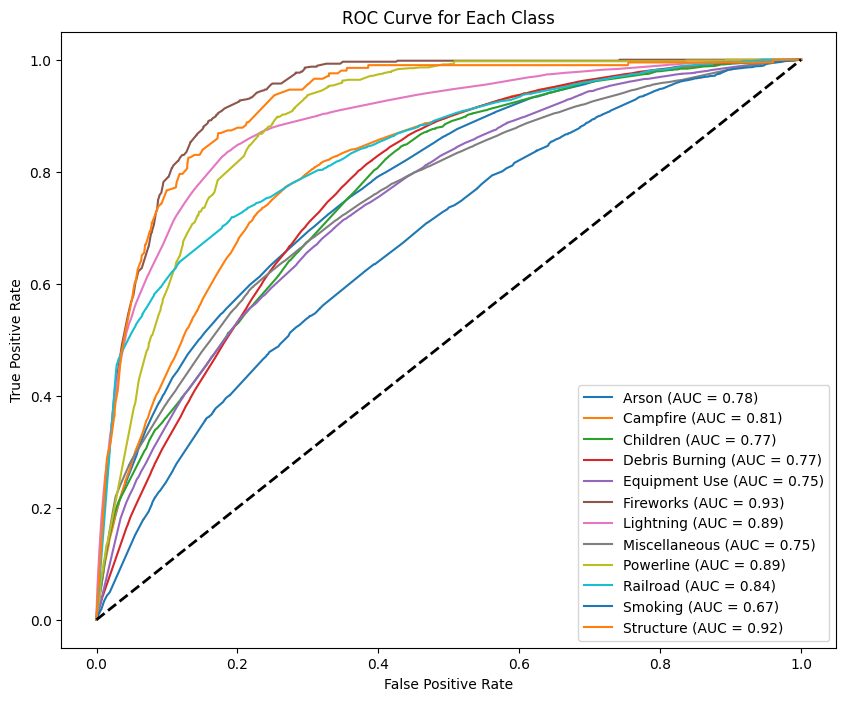

In [6]:
plot_auc_by_class(y_val, y_pred_prob)